In [1]:
%matplotlib inline

from os import listdir, makedirs
from os.path import isfile, join, basename, splitext, isfile, exists
from pathlib import Path

import numpy as np
import pandas as pd

from tqdm import tqdm_notebook

import tensorflow as tf
import keras.backend as K

import keras
from keras.engine.input_layer import Input

import matplotlib.pyplot as plt
import seaborn as sns

import random, os, sys
from keras.models import *
from keras.layers import *
from keras.callbacks import *
from keras.initializers import *
import tensorflow as tf
from keras.engine.topology import Layer

pd.set_option('precision', 30)
np.set_printoptions(precision = 30)

np.random.seed(368)
tf.set_random_seed(368)

Using TensorFlow backend.


In [2]:
DATA = Path('../../Data')

In [3]:
%time train_df = pd.read_csv(DATA/'train.csv', dtype={'acoustic_data': np.int8, 'time_to_failure': np.float32})

Wall time: 1min 44s


In [4]:
train_df.head()

,acoustic_data,time_to_failure
0,12,1.46909999847412109375
1,6,1.46909999847412109375
2,8,1.46909999847412109375
3,5,1.46909999847412109375
4,8,1.46909999847412109375


In [5]:
X_train = train_df.acoustic_data.values
y_train = train_df.time_to_failure.values

Find complete segments in the training data (time to failure goes to zero)

In [6]:
ends_mask = np.less(y_train[:-1], y_train[1:])
segment_ends = np.nonzero(ends_mask)

train_segments = []
start = 0
for end in segment_ends[0]:
    train_segments.append((start, end))
    start = end
    
print(train_segments)

[(0, 5656573), (5656573, 50085877), (50085877, 104677355), (104677355, 138772452), (138772452, 187641819), (187641819, 218652629), (218652629, 245829584), (245829584, 307838916), (307838916, 338276286), (338276286, 375377847), (375377847, 419368879), (419368879, 461811622), (461811622, 495800224), (495800224, 528777114), (528777114, 585568143), (585568143, 621985672)]


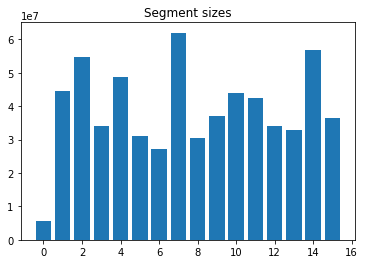

In [7]:
plt.title('Segment sizes')
_ = plt.bar(np.arange(len(train_segments)), [ s[1] - s[0] for s in train_segments])

The generator samples randomly from the segmens without crossing the boundaries

In [8]:
class EarthQuakeRandom(keras.utils.Sequence):

    def __init__(self, x, y, x_mean, x_std, segments, ts_length, batch_size, steps_per_epoch):
        self.x = x
        self.y = y
        self.segments = segments
        self.ts_length = ts_length
        self.batch_size = batch_size
        self.steps_per_epoch = steps_per_epoch
        self.segments_size = np.array([s[1] - s[0] for s in segments])
        self.segments_p = self.segments_size / self.segments_size.sum()
        self.x_mean = x_mean
        self.x_std = x_std

    def get_batch_size(self):
        return self.batch_size

    def get_ts_length(self):
        return self.ts_length

    def get_segments(self):
        return self.segments

    def get_segments_p(self):
        return self.segments_p

    def get_segments_size(self):
        return self.segments_size

    def __len__(self):
        return self.steps_per_epoch

    def __getitem__(self, idx):
        segment_index = np.random.choice(range(len(self.segments)), p=self.segments_p)
        segment = self.segments[segment_index]
        end_indexes = np.random.randint(segment[0] + self.ts_length, segment[1], size=self.batch_size)

        x_batch = np.empty((self.batch_size, self.ts_length))
        y_batch = np.empty(self.batch_size, )

        for i, end in enumerate(end_indexes):
            x_batch[i, :] = self.x[end - self.ts_length: end]
            y_batch[i] = self.y[end - 1]
            
        x_batch = (x_batch - self.x_mean)/self.x_std

        return np.expand_dims(x_batch, axis=2), y_batch

We could use any segments for training / validation

In [9]:
t_segments = [train_segments[i] for i in [ 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]]
v_segments = [train_segments[i] for i in [ 0, 1, 2, 3]]

I think it does not make big difference but lets not leak into the validation data and calculate mean and standrad deviation on the training data only.

In [10]:
x_sum = 0.
count = 0

for s in t_segments:
    x_sum += X_train[s[0]:s[1]].sum()
    count += (s[1] - s[0])

X_train_mean = x_sum/count

x2_sum = 0.
for s in t_segments:
    x2_sum += np.power(X_train[s[0]:s[1]] - X_train_mean, 2).sum()

X_train_std =  np.sqrt(x2_sum/count)

print(X_train_mean, X_train_std)

4.472289301190891 6.189013535612676


In [11]:
train_gen = EarthQuakeRandom(
    x = X_train, 
    y = y_train,
    x_mean = X_train_mean, 
    x_std = X_train_std,
    segments = t_segments,
    ts_length = 150000,
    batch_size = 64,
    steps_per_epoch = 400
)

valid_gen = EarthQuakeRandom(
    x = X_train, 
    y = y_train,
    x_mean = X_train_mean, 
    x_std = X_train_std,
    segments = v_segments,
    ts_length = 150000,
    batch_size = 64,
    steps_per_epoch = 400
)

In [12]:
print(train_gen)

Use convolutional layers to learn the features and reduce the time sequence length 

In [13]:
# https://www.kaggle.com/shujian/transformer-with-lstm

try:
    from dataloader import TokenList, pad_to_longest
    # for transformer
except: pass



embed_size = 60

class LayerNormalization(Layer):
    def __init__(self, eps=1e-6, **kwargs):
        self.eps = eps
        super(LayerNormalization, self).__init__(**kwargs)
    def build(self, input_shape):
        self.gamma = self.add_weight(name='gamma', shape=input_shape[-1:],
                                     initializer=Ones(), trainable=True)
        self.beta = self.add_weight(name='beta', shape=input_shape[-1:],
                                    initializer=Zeros(), trainable=True)
        super(LayerNormalization, self).build(input_shape)
    def call(self, x):
        mean = K.mean(x, axis=-1, keepdims=True)
        std = K.std(x, axis=-1, keepdims=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta
    def compute_output_shape(self, input_shape):
        return input_shape

class ScaledDotProductAttention():
    def __init__(self, d_model, attn_dropout=0.1):
        self.temper = np.sqrt(d_model)
        self.dropout = Dropout(attn_dropout)
    def __call__(self, q, k, v, mask):
        attn = Lambda(lambda x:K.batch_dot(x[0],x[1],axes=[2,2])/self.temper)([q, k])
        if mask is not None:
            mmask = Lambda(lambda x:(-1e+10)*(1-x))(mask)
            attn = Add()([attn, mmask])
        attn = Activation('softmax')(attn)
        attn = self.dropout(attn)
        output = Lambda(lambda x:K.batch_dot(x[0], x[1]))([attn, v])
        return output, attn

class MultiHeadAttention():
    # mode 0 - big martixes, faster; mode 1 - more clear implementation
    def __init__(self, n_head, d_model, d_k, d_v, dropout, mode=0, use_norm=True):
        self.mode = mode
        self.n_head = n_head
        self.d_k = d_k
        self.d_v = d_v
        self.dropout = dropout
        if mode == 0:
            self.qs_layer = Dense(n_head*d_k, use_bias=False)
            self.ks_layer = Dense(n_head*d_k, use_bias=False)
            self.vs_layer = Dense(n_head*d_v, use_bias=False)
        elif mode == 1:
            self.qs_layers = []
            self.ks_layers = []
            self.vs_layers = []
            for _ in range(n_head):
                self.qs_layers.append(TimeDistributed(Dense(d_k, use_bias=False)))
                self.ks_layers.append(TimeDistributed(Dense(d_k, use_bias=False)))
                self.vs_layers.append(TimeDistributed(Dense(d_v, use_bias=False)))
        self.attention = ScaledDotProductAttention(d_model)
        self.layer_norm = LayerNormalization() if use_norm else None
        self.w_o = TimeDistributed(Dense(d_model))

    def __call__(self, q, k, v, mask=None):
        d_k, d_v = self.d_k, self.d_v
        n_head = self.n_head

        if self.mode == 0:
            qs = self.qs_layer(q)  # [batch_size, len_q, n_head*d_k]
            ks = self.ks_layer(k)
            vs = self.vs_layer(v)

            def reshape1(x):
                s = tf.shape(x)   # [batch_size, len_q, n_head * d_k]
                x = tf.reshape(x, [s[0], s[1], n_head, d_k])
                x = tf.transpose(x, [2, 0, 1, 3])  
                x = tf.reshape(x, [-1, s[1], d_k])  # [n_head * batch_size, len_q, d_k]
                return x
            qs = Lambda(reshape1)(qs)
            ks = Lambda(reshape1)(ks)
            vs = Lambda(reshape1)(vs)

            if mask is not None:
                mask = Lambda(lambda x:K.repeat_elements(x, n_head, 0))(mask)
            head, attn = self.attention(qs, ks, vs, mask=mask)  
                
            def reshape2(x):
                s = tf.shape(x)   # [n_head * batch_size, len_v, d_v]
                x = tf.reshape(x, [n_head, -1, s[1], s[2]]) 
                x = tf.transpose(x, [1, 2, 0, 3])
                x = tf.reshape(x, [-1, s[1], n_head*d_v])  # [batch_size, len_v, n_head * d_v]
                return x
            head = Lambda(reshape2)(head)
        elif self.mode == 1:
            heads = []; attns = []
            for i in range(n_head):
                qs = self.qs_layers[i](q)   
                ks = self.ks_layers[i](k) 
                vs = self.vs_layers[i](v) 
                head, attn = self.attention(qs, ks, vs, mask)
                heads.append(head); attns.append(attn)
            head = Concatenate()(heads) if n_head > 1 else heads[0]
            attn = Concatenate()(attns) if n_head > 1 else attns[0]

        outputs = self.w_o(head)
        outputs = Dropout(self.dropout)(outputs)
        if not self.layer_norm: return outputs, attn
        # outputs = Add()([outputs, q]) # sl: fix
        return self.layer_norm(outputs), attn

class PositionwiseFeedForward():
    def __init__(self, d_hid, d_inner_hid, dropout=0.1):
        self.w_1 = Conv1D(d_inner_hid, 1, activation='relu')
        self.w_2 = Conv1D(d_hid, 1)
        self.layer_norm = LayerNormalization()
        self.dropout = Dropout(dropout)
    def __call__(self, x):
        output = self.w_1(x) 
        output = self.w_2(output)
        output = self.dropout(output)
        output = Add()([output, x])
        return self.layer_norm(output)

class EncoderLayer():
    def __init__(self, d_model, d_inner_hid, n_head, d_k, d_v, dropout=0.1):
        self.self_att_layer = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.pos_ffn_layer  = PositionwiseFeedForward(d_model, d_inner_hid, dropout=dropout)
    def __call__(self, enc_input, mask=None):
        output, slf_attn = self.self_att_layer(enc_input, enc_input, enc_input, mask=mask)
        output = self.pos_ffn_layer(output)
        return output, slf_attn


def GetPosEncodingMatrix(max_len, d_emb):
    pos_enc = np.array([
        [pos / np.power(10000, 2 * (j // 2) / d_emb) for j in range(d_emb)] 
        if pos != 0 else np.zeros(d_emb) 
            for pos in range(max_len)
            ])
    pos_enc[1:, 0::2] = np.sin(pos_enc[1:, 0::2]) # dim 2i
    pos_enc[1:, 1::2] = np.cos(pos_enc[1:, 1::2]) # dim 2i+1
    return pos_enc

def GetPadMask(q, k):
    ones = K.expand_dims(K.ones_like(q, 'float32'), -1)
    mask = K.cast(K.expand_dims(K.not_equal(k, 0), 1), 'float32')
    mask = K.batch_dot(ones, mask, axes=[2,1])
    return mask

def GetSubMask(s):
    len_s = tf.shape(s)[1]
    bs = tf.shape(s)[:1]
    mask = K.cumsum(tf.eye(len_s, batch_shape=bs), 1)
    return mask



In [14]:
def CnnTransformerModel():
    i = Input(shape = (150000, 1))
    
    x = Convolution1D( 8, kernel_size = 10, strides = 10, activation='relu')(i)
    x = Convolution1D(16, kernel_size = 10, strides = 10, activation='relu')(x)
    x = Convolution1D(16, kernel_size = 10, strides = 10, activation='relu')(x)
   # x = (CuDNNLSTM(16, return_sequences = True, return_state = False))(x)
    x, slf_attn = MultiHeadAttention(n_head=5, d_model=300, d_k=64, d_v=64, dropout=0.3)(x, x, x)
    avg_pool = GlobalAveragePooling1D()(x)
    
    y = Dense(1)(avg_pool)
    

    return Model(inputs = [i], outputs = [y])

In [15]:
model = CnnTransformerModel()
model.compile(loss='mean_absolute_error', optimizer='adam')
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150000, 1)    0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 15000, 8)     88          input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 1500, 16)     1296        conv1d_1[0][0]                   
__________________________________________________________________________________________________
conv1d_3 (Conv1D)    

Train the model with early stopping

In [16]:
import time
start_time = time.time()
hist = model.fit_generator(
    generator =  train_gen,
    epochs = 20, # 150
    verbose = 1, 
    validation_data = valid_gen,
    callbacks = [
        EarlyStopping(monitor='val_loss', patience = 150, verbose = 1)
    ]
)
print("--- %s seconds ---" % (time.time() - start_time))

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/20


318/400 [======================>.......] - ETA: 32:01 - loss: 4.57 - ETA: 17:27 - loss: 3.56 - ETA: 12:33 - loss: 3.40 - ETA: 10:05 - loss: 3.71 - ETA: 8:38 - loss: 3.5498 - ETA: 7:38 - loss: 3.457 - ETA: 6:56 - loss: 3.423 - ETA: 6:24 - loss: 3.301 - ETA: 5:59 - loss: 3.381 - ETA: 5:39 - loss: 3.298 - ETA: 5:23 - loss: 3.376 - ETA: 5:09 - loss: 3.420 - ETA: 4:57 - loss: 3.482 - ETA: 4:47 - loss: 3.403 - ETA: 4:38 - loss: 3.432 - ETA: 4:31 - loss: 3.451 - ETA: 4:24 - loss: 3.395 - ETA: 4:18 - loss: 3.426 - ETA: 4:12 - loss: 3.395 - ETA: 4:07 - loss: 3.380 - ETA: 4:03 - loss: 3.344 - ETA: 3:58 - loss: 3.282 - ETA: 3:54 - loss: 3.252 - ETA: 3:51 - loss: 3.184 - ETA: 3:48 - loss: 3.133 - ETA: 3:44 - loss: 3.130 - ETA: 3:41 - loss: 3.088 - ETA: 3:39 - loss: 3.036 - ETA: 3:36 - loss: 3.003 - ETA: 3:34 - loss: 3.026 - ETA: 3:31 - loss: 2.997 - ETA: 3:29 - loss: 2.958 - ETA: 3:27 - loss: 2.931 - ETA: 3:25 - loss: 2.982 - ETA: 3:23 - loss: 3.030 - ETA: 3:21 - loss: 3.002 - ETA: 3:19 - loss: 3.

318/400 [======================>.......] - ETA: 3:02 - loss: 2.234 - ETA: 2:59 - loss: 1.933 - ETA: 2:57 - loss: 1.715 - ETA: 2:56 - loss: 1.689 - ETA: 2:54 - loss: 1.552 - ETA: 2:54 - loss: 1.984 - ETA: 2:53 - loss: 1.924 - ETA: 2:52 - loss: 1.847 - ETA: 2:52 - loss: 1.861 - ETA: 2:51 - loss: 1.939 - ETA: 2:50 - loss: 1.890 - ETA: 2:50 - loss: 2.056 - ETA: 2:49 - loss: 2.019 - ETA: 2:49 - loss: 2.197 - ETA: 2:48 - loss: 2.289 - ETA: 2:48 - loss: 2.255 - ETA: 2:47 - loss: 2.258 - ETA: 2:46 - loss: 2.255 - ETA: 2:46 - loss: 2.268 - ETA: 2:45 - loss: 2.341 - ETA: 2:45 - loss: 2.294 - ETA: 2:44 - loss: 2.259 - ETA: 2:44 - loss: 2.247 - ETA: 2:43 - loss: 2.212 - ETA: 2:43 - loss: 2.195 - ETA: 2:43 - loss: 2.165 - ETA: 2:42 - loss: 2.226 - ETA: 2:41 - loss: 2.234 - ETA: 2:41 - loss: 2.198 - ETA: 2:41 - loss: 2.172 - ETA: 2:40 - loss: 2.136 - ETA: 2:40 - loss: 2.243 - ETA: 2:39 - loss: 2.200 - ETA: 2:39 - loss: 2.164 - ETA: 2:38 - loss: 2.193 - ETA: 2:38 - loss: 2.163 - ETA: 2:37 - loss: 2.1

400/400 [==============================] - ETA: 35s - loss: 2.29 - ETA: 34s - loss: 2.29 - ETA: 34s - loss: 2.29 - ETA: 33s - loss: 2.29 - ETA: 33s - loss: 2.29 - ETA: 32s - loss: 2.28 - ETA: 32s - loss: 2.28 - ETA: 31s - loss: 2.28 - ETA: 31s - loss: 2.28 - ETA: 31s - loss: 2.28 - ETA: 30s - loss: 2.28 - ETA: 30s - loss: 2.28 - ETA: 29s - loss: 2.28 - ETA: 29s - loss: 2.27 - ETA: 28s - loss: 2.27 - ETA: 28s - loss: 2.27 - ETA: 28s - loss: 2.27 - ETA: 27s - loss: 2.26 - ETA: 27s - loss: 2.26 - ETA: 26s - loss: 2.26 - ETA: 26s - loss: 2.26 - ETA: 25s - loss: 2.26 - ETA: 25s - loss: 2.26 - ETA: 25s - loss: 2.27 - ETA: 24s - loss: 2.27 - ETA: 24s - loss: 2.27 - ETA: 23s - loss: 2.27 - ETA: 23s - loss: 2.27 - ETA: 22s - loss: 2.27 - ETA: 22s - loss: 2.27 - ETA: 22s - loss: 2.27 - ETA: 21s - loss: 2.27 - ETA: 21s - loss: 2.28 - ETA: 20s - loss: 2.28 - ETA: 20s - loss: 2.28 - ETA: 19s - loss: 2.27 - ETA: 19s - loss: 2.27 - ETA: 19s - loss: 2.28 - ETA: 18s - loss: 2.28 - ETA: 18s - loss: 2.28

318/400 [======================>.......] - ETA: 3:03 - loss: 2.731 - ETA: 3:03 - loss: 3.092 - ETA: 3:02 - loss: 2.549 - ETA: 2:59 - loss: 2.733 - ETA: 2:57 - loss: 2.829 - ETA: 2:56 - loss: 2.711 - ETA: 2:55 - loss: 2.527 - ETA: 2:54 - loss: 2.411 - ETA: 2:53 - loss: 2.352 - ETA: 2:53 - loss: 2.250 - ETA: 2:52 - loss: 2.155 - ETA: 2:51 - loss: 2.354 - ETA: 2:50 - loss: 2.543 - ETA: 2:50 - loss: 2.451 - ETA: 2:49 - loss: 2.406 - ETA: 2:49 - loss: 2.575 - ETA: 2:48 - loss: 2.490 - ETA: 2:47 - loss: 2.434 - ETA: 2:47 - loss: 2.522 - ETA: 2:46 - loss: 2.449 - ETA: 2:45 - loss: 2.396 - ETA: 2:45 - loss: 2.373 - ETA: 2:44 - loss: 2.334 - ETA: 2:44 - loss: 2.299 - ETA: 2:43 - loss: 2.288 - ETA: 2:42 - loss: 2.283 - ETA: 2:42 - loss: 2.277 - ETA: 2:42 - loss: 2.321 - ETA: 2:41 - loss: 2.325 - ETA: 2:41 - loss: 2.318 - ETA: 2:40 - loss: 2.306 - ETA: 2:40 - loss: 2.300 - ETA: 2:39 - loss: 2.333 - ETA: 2:39 - loss: 2.331 - ETA: 2:38 - loss: 2.322 - ETA: 2:38 - loss: 2.328 - ETA: 2:37 - loss: 2.3

318/400 [======================>.......] - ETA: 2:59 - loss: 3.692 - ETA: 3:01 - loss: 2.525 - ETA: 3:00 - loss: 2.047 - ETA: 2:59 - loss: 1.969 - ETA: 2:57 - loss: 1.949 - ETA: 2:55 - loss: 2.041 - ETA: 2:53 - loss: 2.010 - ETA: 2:53 - loss: 2.260 - ETA: 2:52 - loss: 2.251 - ETA: 2:51 - loss: 2.162 - ETA: 2:51 - loss: 2.197 - ETA: 2:50 - loss: 2.134 - ETA: 2:50 - loss: 2.090 - ETA: 2:49 - loss: 2.023 - ETA: 2:48 - loss: 2.167 - ETA: 2:48 - loss: 2.115 - ETA: 2:47 - loss: 2.071 - ETA: 2:47 - loss: 2.010 - ETA: 2:46 - loss: 2.136 - ETA: 2:46 - loss: 2.174 - ETA: 2:45 - loss: 2.256 - ETA: 2:45 - loss: 2.275 - ETA: 2:44 - loss: 2.344 - ETA: 2:44 - loss: 2.306 - ETA: 2:43 - loss: 2.278 - ETA: 2:42 - loss: 2.269 - ETA: 2:42 - loss: 2.242 - ETA: 2:42 - loss: 2.204 - ETA: 2:41 - loss: 2.210 - ETA: 2:41 - loss: 2.198 - ETA: 2:40 - loss: 2.171 - ETA: 2:40 - loss: 2.224 - ETA: 2:39 - loss: 2.224 - ETA: 2:39 - loss: 2.225 - ETA: 2:38 - loss: 2.277 - ETA: 2:38 - loss: 2.259 - ETA: 2:37 - loss: 2.2

400/400 [==============================] - ETA: 35s - loss: 2.29 - ETA: 34s - loss: 2.29 - ETA: 34s - loss: 2.29 - ETA: 33s - loss: 2.29 - ETA: 33s - loss: 2.28 - ETA: 32s - loss: 2.29 - ETA: 32s - loss: 2.29 - ETA: 31s - loss: 2.29 - ETA: 31s - loss: 2.29 - ETA: 31s - loss: 2.29 - ETA: 30s - loss: 2.29 - ETA: 30s - loss: 2.30 - ETA: 29s - loss: 2.30 - ETA: 29s - loss: 2.30 - ETA: 28s - loss: 2.30 - ETA: 28s - loss: 2.30 - ETA: 28s - loss: 2.30 - ETA: 27s - loss: 2.29 - ETA: 27s - loss: 2.29 - ETA: 26s - loss: 2.29 - ETA: 26s - loss: 2.29 - ETA: 25s - loss: 2.29 - ETA: 25s - loss: 2.29 - ETA: 25s - loss: 2.30 - ETA: 24s - loss: 2.29 - ETA: 24s - loss: 2.29 - ETA: 23s - loss: 2.30 - ETA: 23s - loss: 2.30 - ETA: 22s - loss: 2.29 - ETA: 22s - loss: 2.29 - ETA: 22s - loss: 2.29 - ETA: 21s - loss: 2.29 - ETA: 21s - loss: 2.29 - ETA: 20s - loss: 2.29 - ETA: 20s - loss: 2.29 - ETA: 19s - loss: 2.29 - ETA: 19s - loss: 2.29 - ETA: 19s - loss: 2.29 - ETA: 18s - loss: 2.29 - ETA: 18s - loss: 2.29

318/400 [======================>.......] - ETA: 2:57 - loss: 1.846 - ETA: 2:57 - loss: 1.950 - ETA: 2:59 - loss: 1.661 - ETA: 2:56 - loss: 2.184 - ETA: 2:55 - loss: 2.059 - ETA: 2:53 - loss: 2.067 - ETA: 2:52 - loss: 2.070 - ETA: 2:52 - loss: 1.954 - ETA: 2:51 - loss: 2.130 - ETA: 2:50 - loss: 2.268 - ETA: 2:49 - loss: 2.160 - ETA: 2:49 - loss: 2.164 - ETA: 2:48 - loss: 2.129 - ETA: 2:47 - loss: 2.069 - ETA: 2:47 - loss: 2.031 - ETA: 2:46 - loss: 1.972 - ETA: 2:46 - loss: 2.023 - ETA: 2:46 - loss: 2.125 - ETA: 2:45 - loss: 2.164 - ETA: 2:45 - loss: 2.126 - ETA: 2:44 - loss: 2.094 - ETA: 2:43 - loss: 2.185 - ETA: 2:43 - loss: 2.154 - ETA: 2:42 - loss: 2.120 - ETA: 2:42 - loss: 2.093 - ETA: 2:41 - loss: 2.065 - ETA: 2:41 - loss: 2.138 - ETA: 2:41 - loss: 2.203 - ETA: 2:40 - loss: 2.204 - ETA: 2:40 - loss: 2.233 - ETA: 2:39 - loss: 2.264 - ETA: 2:39 - loss: 2.250 - ETA: 2:38 - loss: 2.286 - ETA: 2:38 - loss: 2.287 - ETA: 2:38 - loss: 2.272 - ETA: 2:37 - loss: 2.272 - ETA: 2:37 - loss: 2.2

318/400 [======================>.......] - ETA: 2:55 - loss: 1.586 - ETA: 2:54 - loss: 2.423 - ETA: 2:56 - loss: 2.191 - ETA: 2:55 - loss: 2.582 - ETA: 2:54 - loss: 2.457 - ETA: 2:53 - loss: 2.443 - ETA: 2:52 - loss: 2.546 - ETA: 2:51 - loss: 2.484 - ETA: 2:50 - loss: 2.481 - ETA: 2:50 - loss: 2.476 - ETA: 2:49 - loss: 2.348 - ETA: 2:48 - loss: 2.245 - ETA: 2:48 - loss: 2.194 - ETA: 2:47 - loss: 2.343 - ETA: 2:47 - loss: 2.510 - ETA: 2:46 - loss: 2.454 - ETA: 2:46 - loss: 2.462 - ETA: 2:45 - loss: 2.483 - ETA: 2:45 - loss: 2.431 - ETA: 2:44 - loss: 2.429 - ETA: 2:43 - loss: 2.358 - ETA: 2:43 - loss: 2.328 - ETA: 2:43 - loss: 2.277 - ETA: 2:43 - loss: 2.329 - ETA: 2:42 - loss: 2.381 - ETA: 2:42 - loss: 2.361 - ETA: 2:41 - loss: 2.396 - ETA: 2:41 - loss: 2.429 - ETA: 2:40 - loss: 2.410 - ETA: 2:40 - loss: 2.418 - ETA: 2:39 - loss: 2.438 - ETA: 2:39 - loss: 2.431 - ETA: 2:38 - loss: 2.442 - ETA: 2:38 - loss: 2.432 - ETA: 2:38 - loss: 2.461 - ETA: 2:37 - loss: 2.479 - ETA: 2:37 - loss: 2.4

400/400 [==============================] - ETA: 34s - loss: 2.36 - ETA: 34s - loss: 2.37 - ETA: 34s - loss: 2.37 - ETA: 33s - loss: 2.36 - ETA: 33s - loss: 2.36 - ETA: 32s - loss: 2.36 - ETA: 32s - loss: 2.35 - ETA: 31s - loss: 2.35 - ETA: 31s - loss: 2.35 - ETA: 31s - loss: 2.36 - ETA: 30s - loss: 2.36 - ETA: 30s - loss: 2.36 - ETA: 29s - loss: 2.35 - ETA: 29s - loss: 2.35 - ETA: 28s - loss: 2.36 - ETA: 28s - loss: 2.35 - ETA: 28s - loss: 2.35 - ETA: 27s - loss: 2.34 - ETA: 27s - loss: 2.34 - ETA: 26s - loss: 2.34 - ETA: 26s - loss: 2.34 - ETA: 25s - loss: 2.33 - ETA: 25s - loss: 2.33 - ETA: 25s - loss: 2.33 - ETA: 24s - loss: 2.33 - ETA: 24s - loss: 2.33 - ETA: 23s - loss: 2.33 - ETA: 23s - loss: 2.33 - ETA: 22s - loss: 2.32 - ETA: 22s - loss: 2.32 - ETA: 22s - loss: 2.32 - ETA: 21s - loss: 2.31 - ETA: 21s - loss: 2.32 - ETA: 20s - loss: 2.32 - ETA: 20s - loss: 2.31 - ETA: 19s - loss: 2.32 - ETA: 19s - loss: 2.32 - ETA: 19s - loss: 2.31 - ETA: 18s - loss: 2.31 - ETA: 18s - loss: 2.31

318/400 [======================>.......] - ETA: 2:58 - loss: 2.607 - ETA: 3:01 - loss: 2.531 - ETA: 2:59 - loss: 2.714 - ETA: 2:56 - loss: 2.591 - ETA: 2:55 - loss: 2.551 - ETA: 2:55 - loss: 2.448 - ETA: 2:55 - loss: 2.605 - ETA: 2:54 - loss: 2.514 - ETA: 2:53 - loss: 2.426 - ETA: 2:52 - loss: 2.365 - ETA: 2:52 - loss: 2.274 - ETA: 2:51 - loss: 2.179 - ETA: 2:50 - loss: 2.182 - ETA: 2:49 - loss: 2.124 - ETA: 2:49 - loss: 2.102 - ETA: 2:48 - loss: 2.033 - ETA: 2:48 - loss: 1.997 - ETA: 2:47 - loss: 2.148 - ETA: 2:46 - loss: 2.091 - ETA: 2:46 - loss: 2.035 - ETA: 2:46 - loss: 2.045 - ETA: 2:45 - loss: 2.051 - ETA: 2:44 - loss: 1.998 - ETA: 2:44 - loss: 1.964 - ETA: 2:43 - loss: 1.940 - ETA: 2:43 - loss: 1.947 - ETA: 2:42 - loss: 2.033 - ETA: 2:42 - loss: 2.003 - ETA: 2:41 - loss: 1.973 - ETA: 2:41 - loss: 2.049 - ETA: 2:40 - loss: 2.045 - ETA: 2:40 - loss: 2.049 - ETA: 2:39 - loss: 2.083 - ETA: 2:39 - loss: 2.087 - ETA: 2:38 - loss: 2.123 - ETA: 2:38 - loss: 2.115 - ETA: 2:37 - loss: 2.1

318/400 [======================>.......] - ETA: 3:01 - loss: 1.860 - ETA: 3:01 - loss: 2.856 - ETA: 2:59 - loss: 2.545 - ETA: 2:57 - loss: 2.137 - ETA: 2:55 - loss: 2.041 - ETA: 2:53 - loss: 1.991 - ETA: 2:54 - loss: 2.265 - ETA: 2:52 - loss: 2.118 - ETA: 2:52 - loss: 2.072 - ETA: 2:51 - loss: 2.072 - ETA: 2:50 - loss: 2.020 - ETA: 2:50 - loss: 2.073 - ETA: 2:49 - loss: 2.030 - ETA: 2:49 - loss: 2.114 - ETA: 2:48 - loss: 2.106 - ETA: 2:48 - loss: 2.111 - ETA: 2:47 - loss: 2.121 - ETA: 2:46 - loss: 2.162 - ETA: 2:45 - loss: 2.145 - ETA: 2:45 - loss: 2.155 - ETA: 2:45 - loss: 2.215 - ETA: 2:44 - loss: 2.160 - ETA: 2:44 - loss: 2.228 - ETA: 2:43 - loss: 2.201 - ETA: 2:43 - loss: 2.158 - ETA: 2:42 - loss: 2.122 - ETA: 2:42 - loss: 2.145 - ETA: 2:42 - loss: 2.137 - ETA: 2:41 - loss: 2.116 - ETA: 2:40 - loss: 2.082 - ETA: 2:40 - loss: 2.069 - ETA: 2:40 - loss: 2.111 - ETA: 2:39 - loss: 2.164 - ETA: 2:39 - loss: 2.145 - ETA: 2:38 - loss: 2.131 - ETA: 2:38 - loss: 2.108 - ETA: 2:38 - loss: 2.1

400/400 [==============================] - ETA: 35s - loss: 2.27 - ETA: 34s - loss: 2.27 - ETA: 34s - loss: 2.27 - ETA: 33s - loss: 2.28 - ETA: 33s - loss: 2.29 - ETA: 32s - loss: 2.28 - ETA: 32s - loss: 2.29 - ETA: 32s - loss: 2.29 - ETA: 31s - loss: 2.29 - ETA: 31s - loss: 2.29 - ETA: 30s - loss: 2.29 - ETA: 30s - loss: 2.29 - ETA: 29s - loss: 2.29 - ETA: 29s - loss: 2.29 - ETA: 29s - loss: 2.29 - ETA: 28s - loss: 2.29 - ETA: 28s - loss: 2.29 - ETA: 27s - loss: 2.29 - ETA: 27s - loss: 2.29 - ETA: 26s - loss: 2.29 - ETA: 26s - loss: 2.29 - ETA: 25s - loss: 2.29 - ETA: 25s - loss: 2.29 - ETA: 25s - loss: 2.29 - ETA: 24s - loss: 2.29 - ETA: 24s - loss: 2.29 - ETA: 23s - loss: 2.28 - ETA: 23s - loss: 2.29 - ETA: 22s - loss: 2.30 - ETA: 22s - loss: 2.29 - ETA: 22s - loss: 2.29 - ETA: 21s - loss: 2.29 - ETA: 21s - loss: 2.29 - ETA: 20s - loss: 2.28 - ETA: 20s - loss: 2.28 - ETA: 19s - loss: 2.28 - ETA: 19s - loss: 2.28 - ETA: 19s - loss: 2.28 - ETA: 18s - loss: 2.27 - ETA: 18s - loss: 2.28

318/400 [======================>.......] - ETA: 2:50 - loss: 1.550 - ETA: 2:54 - loss: 1.676 - ETA: 2:56 - loss: 1.572 - ETA: 2:54 - loss: 1.445 - ETA: 2:53 - loss: 1.536 - ETA: 2:52 - loss: 1.559 - ETA: 2:52 - loss: 1.520 - ETA: 2:51 - loss: 1.679 - ETA: 2:51 - loss: 1.628 - ETA: 2:50 - loss: 1.592 - ETA: 2:50 - loss: 1.548 - ETA: 2:49 - loss: 1.772 - ETA: 2:49 - loss: 1.720 - ETA: 2:48 - loss: 1.689 - ETA: 2:47 - loss: 1.649 - ETA: 2:47 - loss: 1.600 - ETA: 2:46 - loss: 1.591 - ETA: 2:46 - loss: 1.647 - ETA: 2:45 - loss: 1.827 - ETA: 2:45 - loss: 1.786 - ETA: 2:45 - loss: 1.826 - ETA: 2:44 - loss: 1.813 - ETA: 2:44 - loss: 1.770 - ETA: 2:43 - loss: 1.867 - ETA: 2:43 - loss: 1.969 - ETA: 2:42 - loss: 1.976 - ETA: 2:41 - loss: 2.048 - ETA: 2:41 - loss: 2.039 - ETA: 2:40 - loss: 2.038 - ETA: 2:40 - loss: 2.031 - ETA: 2:40 - loss: 2.029 - ETA: 2:39 - loss: 2.070 - ETA: 2:39 - loss: 2.079 - ETA: 2:38 - loss: 2.130 - ETA: 2:38 - loss: 2.159 - ETA: 2:37 - loss: 2.149 - ETA: 2:37 - loss: 2.1

318/400 [======================>.......] - ETA: 2:55 - loss: 1.632 - ETA: 2:54 - loss: 2.012 - ETA: 2:55 - loss: 2.373 - ETA: 2:54 - loss: 2.135 - ETA: 2:54 - loss: 2.276 - ETA: 2:53 - loss: 2.288 - ETA: 2:51 - loss: 2.385 - ETA: 2:51 - loss: 2.290 - ETA: 2:51 - loss: 2.215 - ETA: 2:50 - loss: 2.182 - ETA: 2:50 - loss: 2.109 - ETA: 2:49 - loss: 2.133 - ETA: 2:48 - loss: 2.093 - ETA: 2:48 - loss: 2.124 - ETA: 2:47 - loss: 2.059 - ETA: 2:47 - loss: 2.012 - ETA: 2:46 - loss: 2.170 - ETA: 2:46 - loss: 2.111 - ETA: 2:45 - loss: 2.155 - ETA: 2:45 - loss: 2.118 - ETA: 2:44 - loss: 2.074 - ETA: 2:44 - loss: 2.055 - ETA: 2:43 - loss: 2.009 - ETA: 2:43 - loss: 2.034 - ETA: 2:42 - loss: 2.008 - ETA: 2:42 - loss: 2.048 - ETA: 2:41 - loss: 2.012 - ETA: 2:41 - loss: 2.099 - ETA: 2:40 - loss: 2.072 - ETA: 2:40 - loss: 2.042 - ETA: 2:39 - loss: 2.009 - ETA: 2:39 - loss: 2.028 - ETA: 2:39 - loss: 2.029 - ETA: 2:38 - loss: 1.996 - ETA: 2:38 - loss: 2.040 - ETA: 2:37 - loss: 2.084 - ETA: 2:37 - loss: 2.0

400/400 [==============================] - ETA: 34s - loss: 2.26 - ETA: 34s - loss: 2.26 - ETA: 34s - loss: 2.25 - ETA: 33s - loss: 2.25 - ETA: 33s - loss: 2.25 - ETA: 32s - loss: 2.25 - ETA: 32s - loss: 2.25 - ETA: 31s - loss: 2.25 - ETA: 31s - loss: 2.24 - ETA: 31s - loss: 2.24 - ETA: 30s - loss: 2.24 - ETA: 30s - loss: 2.24 - ETA: 29s - loss: 2.24 - ETA: 29s - loss: 2.23 - ETA: 28s - loss: 2.23 - ETA: 28s - loss: 2.23 - ETA: 28s - loss: 2.23 - ETA: 27s - loss: 2.23 - ETA: 27s - loss: 2.22 - ETA: 26s - loss: 2.22 - ETA: 26s - loss: 2.22 - ETA: 25s - loss: 2.22 - ETA: 25s - loss: 2.23 - ETA: 25s - loss: 2.22 - ETA: 24s - loss: 2.22 - ETA: 24s - loss: 2.23 - ETA: 23s - loss: 2.22 - ETA: 23s - loss: 2.23 - ETA: 22s - loss: 2.22 - ETA: 22s - loss: 2.22 - ETA: 22s - loss: 2.22 - ETA: 21s - loss: 2.22 - ETA: 21s - loss: 2.22 - ETA: 20s - loss: 2.21 - ETA: 20s - loss: 2.21 - ETA: 19s - loss: 2.22 - ETA: 19s - loss: 2.22 - ETA: 18s - loss: 2.22 - ETA: 18s - loss: 2.22 - ETA: 18s - loss: 2.22

318/400 [======================>.......] - ETA: 3:01 - loss: 1.691 - ETA: 2:57 - loss: 1.692 - ETA: 2:57 - loss: 2.055 - ETA: 2:56 - loss: 2.020 - ETA: 2:54 - loss: 2.348 - ETA: 2:53 - loss: 2.144 - ETA: 2:53 - loss: 2.345 - ETA: 2:52 - loss: 2.252 - ETA: 2:51 - loss: 2.416 - ETA: 2:50 - loss: 2.362 - ETA: 2:50 - loss: 2.329 - ETA: 2:49 - loss: 2.318 - ETA: 2:48 - loss: 2.309 - ETA: 2:48 - loss: 2.302 - ETA: 2:47 - loss: 2.374 - ETA: 2:47 - loss: 2.398 - ETA: 2:46 - loss: 2.423 - ETA: 2:46 - loss: 2.366 - ETA: 2:45 - loss: 2.312 - ETA: 2:44 - loss: 2.418 - ETA: 2:44 - loss: 2.390 - ETA: 2:43 - loss: 2.367 - ETA: 2:43 - loss: 2.425 - ETA: 2:42 - loss: 2.419 - ETA: 2:42 - loss: 2.506 - ETA: 2:42 - loss: 2.568 - ETA: 2:41 - loss: 2.534 - ETA: 2:40 - loss: 2.566 - ETA: 2:40 - loss: 2.619 - ETA: 2:39 - loss: 2.619 - ETA: 2:39 - loss: 2.611 - ETA: 2:39 - loss: 2.629 - ETA: 2:38 - loss: 2.596 - ETA: 2:38 - loss: 2.581 - ETA: 2:38 - loss: 2.591 - ETA: 2:37 - loss: 2.613 - ETA: 2:37 - loss: 2.6

318/400 [======================>.......] - ETA: 2:57 - loss: 2.619 - ETA: 2:55 - loss: 2.614 - ETA: 2:57 - loss: 2.023 - ETA: 2:55 - loss: 1.994 - ETA: 2:54 - loss: 2.314 - ETA: 2:53 - loss: 2.178 - ETA: 2:52 - loss: 2.010 - ETA: 2:51 - loss: 2.252 - ETA: 2:50 - loss: 2.257 - ETA: 2:50 - loss: 2.170 - ETA: 2:49 - loss: 2.102 - ETA: 2:49 - loss: 2.037 - ETA: 2:48 - loss: 1.986 - ETA: 2:47 - loss: 1.952 - ETA: 2:47 - loss: 1.899 - ETA: 2:46 - loss: 2.039 - ETA: 2:46 - loss: 2.005 - ETA: 2:45 - loss: 1.948 - ETA: 2:45 - loss: 2.091 - ETA: 2:44 - loss: 2.264 - ETA: 2:44 - loss: 2.211 - ETA: 2:43 - loss: 2.194 - ETA: 2:43 - loss: 2.138 - ETA: 2:42 - loss: 2.107 - ETA: 2:42 - loss: 2.106 - ETA: 2:42 - loss: 2.095 - ETA: 2:41 - loss: 2.089 - ETA: 2:41 - loss: 2.064 - ETA: 2:40 - loss: 2.127 - ETA: 2:40 - loss: 2.107 - ETA: 2:39 - loss: 2.132 - ETA: 2:39 - loss: 2.140 - ETA: 2:38 - loss: 2.094 - ETA: 2:38 - loss: 2.072 - ETA: 2:38 - loss: 2.130 - ETA: 2:37 - loss: 2.176 - ETA: 2:37 - loss: 2.1

400/400 [==============================] - ETA: 34s - loss: 2.24 - ETA: 34s - loss: 2.24 - ETA: 34s - loss: 2.25 - ETA: 33s - loss: 2.24 - ETA: 33s - loss: 2.25 - ETA: 32s - loss: 2.24 - ETA: 32s - loss: 2.24 - ETA: 31s - loss: 2.24 - ETA: 31s - loss: 2.24 - ETA: 31s - loss: 2.25 - ETA: 30s - loss: 2.24 - ETA: 30s - loss: 2.24 - ETA: 29s - loss: 2.24 - ETA: 29s - loss: 2.24 - ETA: 28s - loss: 2.24 - ETA: 28s - loss: 2.24 - ETA: 28s - loss: 2.24 - ETA: 27s - loss: 2.25 - ETA: 27s - loss: 2.24 - ETA: 26s - loss: 2.24 - ETA: 26s - loss: 2.24 - ETA: 25s - loss: 2.24 - ETA: 25s - loss: 2.23 - ETA: 25s - loss: 2.23 - ETA: 24s - loss: 2.24 - ETA: 24s - loss: 2.24 - ETA: 23s - loss: 2.23 - ETA: 23s - loss: 2.24 - ETA: 22s - loss: 2.24 - ETA: 22s - loss: 2.23 - ETA: 22s - loss: 2.24 - ETA: 21s - loss: 2.24 - ETA: 21s - loss: 2.23 - ETA: 20s - loss: 2.24 - ETA: 20s - loss: 2.24 - ETA: 19s - loss: 2.24 - ETA: 19s - loss: 2.24 - ETA: 18s - loss: 2.24 - ETA: 18s - loss: 2.24 - ETA: 18s - loss: 2.24

318/400 [======================>.......] - ETA: 2:57 - loss: 2.831 - ETA: 2:58 - loss: 2.490 - ETA: 2:57 - loss: 1.946 - ETA: 2:56 - loss: 2.390 - ETA: 2:54 - loss: 2.117 - ETA: 2:53 - loss: 2.338 - ETA: 2:52 - loss: 2.148 - ETA: 2:51 - loss: 2.082 - ETA: 2:51 - loss: 2.010 - ETA: 2:50 - loss: 2.123 - ETA: 2:49 - loss: 2.091 - ETA: 2:48 - loss: 2.050 - ETA: 2:48 - loss: 2.040 - ETA: 2:48 - loss: 2.110 - ETA: 2:47 - loss: 2.184 - ETA: 2:47 - loss: 2.175 - ETA: 2:46 - loss: 2.159 - ETA: 2:46 - loss: 2.152 - ETA: 2:45 - loss: 2.151 - ETA: 2:45 - loss: 2.111 - ETA: 2:44 - loss: 2.133 - ETA: 2:44 - loss: 2.136 - ETA: 2:43 - loss: 2.200 - ETA: 2:43 - loss: 2.188 - ETA: 2:42 - loss: 2.161 - ETA: 2:42 - loss: 2.198 - ETA: 2:41 - loss: 2.166 - ETA: 2:41 - loss: 2.191 - ETA: 2:40 - loss: 2.169 - ETA: 2:40 - loss: 2.136 - ETA: 2:39 - loss: 2.183 - ETA: 2:39 - loss: 2.245 - ETA: 2:38 - loss: 2.219 - ETA: 2:38 - loss: 2.287 - ETA: 2:38 - loss: 2.303 - ETA: 2:37 - loss: 2.275 - ETA: 2:37 - loss: 2.3

318/400 [======================>.......] - ETA: 2:59 - loss: 2.433 - ETA: 2:59 - loss: 2.829 - ETA: 2:59 - loss: 2.333 - ETA: 2:57 - loss: 2.448 - ETA: 2:54 - loss: 2.262 - ETA: 2:54 - loss: 2.163 - ETA: 2:53 - loss: 2.043 - ETA: 2:52 - loss: 2.276 - ETA: 2:51 - loss: 2.248 - ETA: 2:50 - loss: 2.132 - ETA: 2:49 - loss: 2.309 - ETA: 2:49 - loss: 2.470 - ETA: 2:48 - loss: 2.367 - ETA: 2:48 - loss: 2.281 - ETA: 2:47 - loss: 2.195 - ETA: 2:47 - loss: 2.114 - ETA: 2:46 - loss: 2.051 - ETA: 2:46 - loss: 1.995 - ETA: 2:45 - loss: 1.957 - ETA: 2:45 - loss: 1.911 - ETA: 2:44 - loss: 1.878 - ETA: 2:44 - loss: 1.931 - ETA: 2:43 - loss: 1.896 - ETA: 2:43 - loss: 1.925 - ETA: 2:42 - loss: 1.890 - ETA: 2:42 - loss: 1.883 - ETA: 2:41 - loss: 1.846 - ETA: 2:41 - loss: 1.823 - ETA: 2:40 - loss: 1.809 - ETA: 2:40 - loss: 1.887 - ETA: 2:40 - loss: 1.960 - ETA: 2:39 - loss: 1.927 - ETA: 2:39 - loss: 1.929 - ETA: 2:38 - loss: 1.909 - ETA: 2:38 - loss: 1.884 - ETA: 2:37 - loss: 1.900 - ETA: 2:37 - loss: 1.9

400/400 [==============================] - ETA: 34s - loss: 2.11 - ETA: 34s - loss: 2.11 - ETA: 34s - loss: 2.11 - ETA: 33s - loss: 2.12 - ETA: 33s - loss: 2.12 - ETA: 32s - loss: 2.12 - ETA: 32s - loss: 2.12 - ETA: 31s - loss: 2.12 - ETA: 31s - loss: 2.12 - ETA: 31s - loss: 2.12 - ETA: 30s - loss: 2.12 - ETA: 30s - loss: 2.12 - ETA: 29s - loss: 2.11 - ETA: 29s - loss: 2.11 - ETA: 28s - loss: 2.11 - ETA: 28s - loss: 2.11 - ETA: 28s - loss: 2.11 - ETA: 27s - loss: 2.11 - ETA: 27s - loss: 2.11 - ETA: 26s - loss: 2.11 - ETA: 26s - loss: 2.12 - ETA: 25s - loss: 2.12 - ETA: 25s - loss: 2.12 - ETA: 25s - loss: 2.12 - ETA: 24s - loss: 2.12 - ETA: 24s - loss: 2.12 - ETA: 23s - loss: 2.12 - ETA: 23s - loss: 2.12 - ETA: 22s - loss: 2.12 - ETA: 22s - loss: 2.12 - ETA: 22s - loss: 2.12 - ETA: 21s - loss: 2.12 - ETA: 21s - loss: 2.12 - ETA: 20s - loss: 2.13 - ETA: 20s - loss: 2.12 - ETA: 19s - loss: 2.12 - ETA: 19s - loss: 2.12 - ETA: 19s - loss: 2.12 - ETA: 18s - loss: 2.12 - ETA: 18s - loss: 2.12

318/400 [======================>.......] - ETA: 2:56 - loss: 3.725 - ETA: 2:56 - loss: 3.622 - ETA: 2:56 - loss: 2.806 - ETA: 2:55 - loss: 2.514 - ETA: 2:53 - loss: 2.615 - ETA: 2:52 - loss: 2.763 - ETA: 2:52 - loss: 2.635 - ETA: 2:51 - loss: 2.530 - ETA: 2:50 - loss: 2.410 - ETA: 2:49 - loss: 2.516 - ETA: 2:49 - loss: 2.454 - ETA: 2:48 - loss: 2.355 - ETA: 2:48 - loss: 2.346 - ETA: 2:47 - loss: 2.319 - ETA: 2:47 - loss: 2.438 - ETA: 2:46 - loss: 2.488 - ETA: 2:46 - loss: 2.464 - ETA: 2:45 - loss: 2.403 - ETA: 2:45 - loss: 2.352 - ETA: 2:44 - loss: 2.337 - ETA: 2:44 - loss: 2.309 - ETA: 2:43 - loss: 2.386 - ETA: 2:43 - loss: 2.337 - ETA: 2:42 - loss: 2.315 - ETA: 2:42 - loss: 2.390 - ETA: 2:41 - loss: 2.407 - ETA: 2:41 - loss: 2.356 - ETA: 2:40 - loss: 2.409 - ETA: 2:40 - loss: 2.387 - ETA: 2:40 - loss: 2.435 - ETA: 2:39 - loss: 2.421 - ETA: 2:39 - loss: 2.413 - ETA: 2:38 - loss: 2.392 - ETA: 2:38 - loss: 2.345 - ETA: 2:37 - loss: 2.316 - ETA: 2:37 - loss: 2.351 - ETA: 2:36 - loss: 2.3

318/400 [======================>.......] - ETA: 3:07 - loss: 1.507 - ETA: 3:04 - loss: 2.494 - ETA: 3:01 - loss: 2.830 - ETA: 2:59 - loss: 2.577 - ETA: 2:56 - loss: 2.570 - ETA: 2:54 - loss: 2.809 - ETA: 2:53 - loss: 2.670 - ETA: 2:52 - loss: 2.564 - ETA: 2:52 - loss: 2.607 - ETA: 2:51 - loss: 2.682 - ETA: 2:50 - loss: 2.743 - ETA: 2:49 - loss: 2.746 - ETA: 2:48 - loss: 2.756 - ETA: 2:48 - loss: 2.666 - ETA: 2:48 - loss: 2.696 - ETA: 2:47 - loss: 2.677 - ETA: 2:46 - loss: 2.612 - ETA: 2:46 - loss: 2.537 - ETA: 2:46 - loss: 2.534 - ETA: 2:45 - loss: 2.463 - ETA: 2:45 - loss: 2.390 - ETA: 2:44 - loss: 2.315 - ETA: 2:44 - loss: 2.298 - ETA: 2:43 - loss: 2.319 - ETA: 2:42 - loss: 2.313 - ETA: 2:42 - loss: 2.280 - ETA: 2:42 - loss: 2.367 - ETA: 2:41 - loss: 2.308 - ETA: 2:41 - loss: 2.277 - ETA: 2:40 - loss: 2.252 - ETA: 2:40 - loss: 2.238 - ETA: 2:39 - loss: 2.223 - ETA: 2:39 - loss: 2.213 - ETA: 2:39 - loss: 2.195 - ETA: 2:38 - loss: 2.170 - ETA: 2:38 - loss: 2.220 - ETA: 2:37 - loss: 2.1

400/400 [==============================] - ETA: 34s - loss: 2.25 - ETA: 34s - loss: 2.25 - ETA: 34s - loss: 2.24 - ETA: 33s - loss: 2.24 - ETA: 33s - loss: 2.24 - ETA: 32s - loss: 2.24 - ETA: 32s - loss: 2.24 - ETA: 31s - loss: 2.24 - ETA: 31s - loss: 2.24 - ETA: 31s - loss: 2.24 - ETA: 30s - loss: 2.24 - ETA: 30s - loss: 2.24 - ETA: 29s - loss: 2.24 - ETA: 29s - loss: 2.24 - ETA: 28s - loss: 2.24 - ETA: 28s - loss: 2.24 - ETA: 28s - loss: 2.24 - ETA: 27s - loss: 2.24 - ETA: 27s - loss: 2.25 - ETA: 26s - loss: 2.24 - ETA: 26s - loss: 2.25 - ETA: 25s - loss: 2.25 - ETA: 25s - loss: 2.25 - ETA: 24s - loss: 2.25 - ETA: 24s - loss: 2.25 - ETA: 24s - loss: 2.25 - ETA: 23s - loss: 2.25 - ETA: 23s - loss: 2.25 - ETA: 22s - loss: 2.25 - ETA: 22s - loss: 2.25 - ETA: 21s - loss: 2.25 - ETA: 21s - loss: 2.25 - ETA: 21s - loss: 2.25 - ETA: 20s - loss: 2.25 - ETA: 20s - loss: 2.25 - ETA: 19s - loss: 2.25 - ETA: 19s - loss: 2.26 - ETA: 18s - loss: 2.26 - ETA: 18s - loss: 2.26 - ETA: 18s - loss: 2.26

318/400 [======================>.......] - ETA: 2:54 - loss: 1.627 - ETA: 2:55 - loss: 2.142 - ETA: 2:55 - loss: 1.749 - ETA: 2:54 - loss: 1.885 - ETA: 2:53 - loss: 1.987 - ETA: 2:51 - loss: 2.469 - ETA: 2:51 - loss: 2.503 - ETA: 2:51 - loss: 2.297 - ETA: 2:50 - loss: 2.186 - ETA: 2:49 - loss: 2.139 - ETA: 2:49 - loss: 2.056 - ETA: 2:48 - loss: 2.088 - ETA: 2:48 - loss: 2.242 - ETA: 2:47 - loss: 2.339 - ETA: 2:47 - loss: 2.334 - ETA: 2:46 - loss: 2.338 - ETA: 2:45 - loss: 2.298 - ETA: 2:45 - loss: 2.305 - ETA: 2:45 - loss: 2.327 - ETA: 2:44 - loss: 2.397 - ETA: 2:44 - loss: 2.384 - ETA: 2:43 - loss: 2.399 - ETA: 2:43 - loss: 2.451 - ETA: 2:42 - loss: 2.488 - ETA: 2:42 - loss: 2.482 - ETA: 2:42 - loss: 2.453 - ETA: 2:41 - loss: 2.410 - ETA: 2:41 - loss: 2.373 - ETA: 2:40 - loss: 2.346 - ETA: 2:40 - loss: 2.312 - ETA: 2:39 - loss: 2.353 - ETA: 2:39 - loss: 2.318 - ETA: 2:39 - loss: 2.316 - ETA: 2:38 - loss: 2.278 - ETA: 2:38 - loss: 2.250 - ETA: 2:37 - loss: 2.219 - ETA: 2:37 - loss: 2.2

318/400 [======================>.......] - ETA: 2:54 - loss: 1.147 - ETA: 2:56 - loss: 1.696 - ETA: 2:57 - loss: 2.212 - ETA: 2:56 - loss: 1.972 - ETA: 2:55 - loss: 1.878 - ETA: 2:53 - loss: 2.032 - ETA: 2:52 - loss: 1.939 - ETA: 2:52 - loss: 1.939 - ETA: 2:51 - loss: 1.948 - ETA: 2:50 - loss: 1.907 - ETA: 2:50 - loss: 1.931 - ETA: 2:49 - loss: 1.985 - ETA: 2:48 - loss: 1.907 - ETA: 2:48 - loss: 1.827 - ETA: 2:47 - loss: 1.834 - ETA: 2:47 - loss: 1.845 - ETA: 2:46 - loss: 1.895 - ETA: 2:46 - loss: 1.898 - ETA: 2:45 - loss: 1.891 - ETA: 2:45 - loss: 1.850 - ETA: 2:44 - loss: 1.841 - ETA: 2:44 - loss: 1.869 - ETA: 2:43 - loss: 1.866 - ETA: 2:43 - loss: 1.921 - ETA: 2:43 - loss: 1.982 - ETA: 2:42 - loss: 1.950 - ETA: 2:41 - loss: 1.967 - ETA: 2:41 - loss: 1.943 - ETA: 2:41 - loss: 1.971 - ETA: 2:40 - loss: 1.961 - ETA: 2:39 - loss: 1.955 - ETA: 2:39 - loss: 1.981 - ETA: 2:39 - loss: 2.006 - ETA: 2:38 - loss: 2.012 - ETA: 2:38 - loss: 2.040 - ETA: 2:37 - loss: 2.028 - ETA: 2:37 - loss: 2.0

400/400 [==============================] - ETA: 35s - loss: 2.26 - ETA: 34s - loss: 2.26 - ETA: 34s - loss: 2.25 - ETA: 33s - loss: 2.25 - ETA: 33s - loss: 2.25 - ETA: 32s - loss: 2.25 - ETA: 32s - loss: 2.24 - ETA: 32s - loss: 2.24 - ETA: 31s - loss: 2.24 - ETA: 31s - loss: 2.23 - ETA: 30s - loss: 2.24 - ETA: 30s - loss: 2.25 - ETA: 29s - loss: 2.25 - ETA: 29s - loss: 2.25 - ETA: 28s - loss: 2.24 - ETA: 28s - loss: 2.25 - ETA: 28s - loss: 2.25 - ETA: 27s - loss: 2.25 - ETA: 27s - loss: 2.25 - ETA: 26s - loss: 2.26 - ETA: 26s - loss: 2.25 - ETA: 25s - loss: 2.25 - ETA: 25s - loss: 2.25 - ETA: 25s - loss: 2.25 - ETA: 24s - loss: 2.25 - ETA: 24s - loss: 2.25 - ETA: 23s - loss: 2.25 - ETA: 23s - loss: 2.25 - ETA: 22s - loss: 2.25 - ETA: 22s - loss: 2.25 - ETA: 22s - loss: 2.24 - ETA: 21s - loss: 2.24 - ETA: 21s - loss: 2.24 - ETA: 20s - loss: 2.24 - ETA: 20s - loss: 2.24 - ETA: 19s - loss: 2.24 - ETA: 19s - loss: 2.24 - ETA: 19s - loss: 2.24 - ETA: 18s - loss: 2.24 - ETA: 18s - loss: 2.24

318/400 [======================>.......] - ETA: 3:00 - loss: 1.277 - ETA: 3:01 - loss: 1.712 - ETA: 3:00 - loss: 1.589 - ETA: 3:01 - loss: 2.144 - ETA: 3:00 - loss: 2.419 - ETA: 2:58 - loss: 2.165 - ETA: 2:57 - loss: 2.032 - ETA: 2:56 - loss: 2.248 - ETA: 2:55 - loss: 2.194 - ETA: 2:55 - loss: 2.155 - ETA: 2:54 - loss: 2.283 - ETA: 2:53 - loss: 2.234 - ETA: 2:53 - loss: 2.393 - ETA: 2:52 - loss: 2.389 - ETA: 2:51 - loss: 2.333 - ETA: 2:50 - loss: 2.284 - ETA: 2:50 - loss: 2.262 - ETA: 2:49 - loss: 2.239 - ETA: 2:49 - loss: 2.325 - ETA: 2:48 - loss: 2.305 - ETA: 2:47 - loss: 2.396 - ETA: 2:47 - loss: 2.322 - ETA: 2:46 - loss: 2.295 - ETA: 2:46 - loss: 2.364 - ETA: 2:45 - loss: 2.313 - ETA: 2:45 - loss: 2.267 - ETA: 2:44 - loss: 2.259 - ETA: 2:44 - loss: 2.333 - ETA: 2:43 - loss: 2.302 - ETA: 2:43 - loss: 2.347 - ETA: 2:42 - loss: 2.312 - ETA: 2:42 - loss: 2.271 - ETA: 2:41 - loss: 2.236 - ETA: 2:41 - loss: 2.262 - ETA: 2:40 - loss: 2.313 - ETA: 2:40 - loss: 2.359 - ETA: 2:39 - loss: 2.3

318/400 [======================>.......] - ETA: 2:56 - loss: 4.723 - ETA: 2:55 - loss: 3.404 - ETA: 2:56 - loss: 3.182 - ETA: 2:55 - loss: 3.086 - ETA: 2:55 - loss: 2.648 - ETA: 2:53 - loss: 2.834 - ETA: 2:52 - loss: 2.627 - ETA: 2:52 - loss: 2.550 - ETA: 2:51 - loss: 2.408 - ETA: 2:51 - loss: 2.582 - ETA: 2:51 - loss: 2.413 - ETA: 2:50 - loss: 2.359 - ETA: 2:49 - loss: 2.278 - ETA: 2:49 - loss: 2.291 - ETA: 2:48 - loss: 2.294 - ETA: 2:48 - loss: 2.394 - ETA: 2:47 - loss: 2.329 - ETA: 2:47 - loss: 2.400 - ETA: 2:46 - loss: 2.473 - ETA: 2:45 - loss: 2.427 - ETA: 2:45 - loss: 2.370 - ETA: 2:44 - loss: 2.333 - ETA: 2:44 - loss: 2.292 - ETA: 2:43 - loss: 2.268 - ETA: 2:43 - loss: 2.244 - ETA: 2:43 - loss: 2.288 - ETA: 2:42 - loss: 2.303 - ETA: 2:42 - loss: 2.287 - ETA: 2:41 - loss: 2.284 - ETA: 2:41 - loss: 2.287 - ETA: 2:40 - loss: 2.324 - ETA: 2:40 - loss: 2.294 - ETA: 2:39 - loss: 2.331 - ETA: 2:39 - loss: 2.322 - ETA: 2:38 - loss: 2.307 - ETA: 2:38 - loss: 2.293 - ETA: 2:37 - loss: 2.3

400/400 [==============================] - ETA: 35s - loss: 2.28 - ETA: 34s - loss: 2.29 - ETA: 34s - loss: 2.29 - ETA: 33s - loss: 2.30 - ETA: 33s - loss: 2.29 - ETA: 33s - loss: 2.29 - ETA: 32s - loss: 2.30 - ETA: 32s - loss: 2.30 - ETA: 31s - loss: 2.30 - ETA: 31s - loss: 2.30 - ETA: 30s - loss: 2.29 - ETA: 30s - loss: 2.29 - ETA: 30s - loss: 2.29 - ETA: 29s - loss: 2.29 - ETA: 29s - loss: 2.29 - ETA: 28s - loss: 2.28 - ETA: 28s - loss: 2.28 - ETA: 27s - loss: 2.28 - ETA: 27s - loss: 2.28 - ETA: 26s - loss: 2.28 - ETA: 26s - loss: 2.28 - ETA: 26s - loss: 2.28 - ETA: 25s - loss: 2.28 - ETA: 25s - loss: 2.28 - ETA: 24s - loss: 2.28 - ETA: 24s - loss: 2.28 - ETA: 23s - loss: 2.27 - ETA: 23s - loss: 2.28 - ETA: 23s - loss: 2.27 - ETA: 22s - loss: 2.27 - ETA: 22s - loss: 2.28 - ETA: 21s - loss: 2.27 - ETA: 21s - loss: 2.27 - ETA: 20s - loss: 2.27 - ETA: 20s - loss: 2.27 - ETA: 19s - loss: 2.27 - ETA: 19s - loss: 2.27 - ETA: 19s - loss: 2.27 - ETA: 18s - loss: 2.28 - ETA: 18s - loss: 2.28

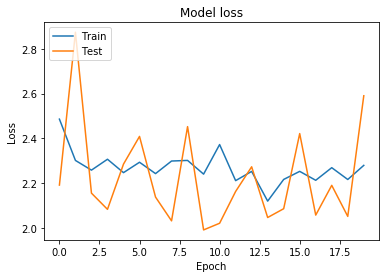

In [17]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
_= plt.legend(['Train', 'Test'], loc='upper left')

In [18]:
import gc
# del train_gen
# del valid_gen
# del X_train
# del y_train
# del train_df
gc.collect()


3561

In [19]:
model.save_weights('./trained_model.h5', overwrite=True)

Load and normalize the test data

In [20]:
def load_test(ts_length = 150000):
    base_dir = DATA/'test'
    test_files = [f for f in listdir(base_dir) if isfile(join(base_dir, f))]

    ts = np.empty([len(test_files), ts_length])
    ids = []
    
    i = 0
    for f in tqdm_notebook(test_files):
        ids.append(splitext(f)[0])
        t_df = pd.read_csv(base_dir/f, dtype={"acoustic_data": np.int8})
        ts[i, :] = t_df['acoustic_data'].values
        i = i + 1

    return ts, ids

In [21]:
test_data, test_ids = load_test()

TypeError: unsupported operand type(s) for +: 'WindowsPath' and 'str'

In [ ]:
X_test = ((test_data - X_train_mean)/ X_train_std)
X_test = np.expand_dims(X_test, 2)
X_test.shape

Load best model and predict

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
submission_df = pd.DataFrame({'seg_id': test_ids, 'time_to_failure': y_pred[:, 0]})

In [ ]:
submission_df.to_csv("submission.csv", index=False)